In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score,average_precision_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, LabelEncoder

In [2]:
train = pd.read_csv("../input/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv")
test = pd.read_csv("../input/DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv")
train_label = pd.read_csv("../input/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv")
submission_format = pd.read_csv("../input/DengAI_Predicting_Disease_Spread_-_Submission_Format.csv")

In [3]:
full_data = pd.concat([train, test], ignore_index=True)

In [4]:
full_data.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1872.000000,1872.000000,1635.000000,1809.000000,1849.000000,1849.000000,1857.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.00000,1860.000000,1857.000000,1860.000000,1860.000000,1817.000000,1817.000000,1849.000000,1849.000000,1845.000000
mean,2003.194979,26.489316,0.138588,0.129713,0.204663,0.202174,44.109278,298.727770,299.253955,295.284823,303.470806,295.724570,40.60128,82.237158,44.109278,16.786638,4.952903,27.226651,8.004112,32.470795,22.160790,38.201897
std,6.292268,15.006319,0.146413,0.125082,0.075064,0.085768,42.065868,1.387410,1.272510,1.528046,3.205739,2.609461,44.70528,7.203803,42.065868,1.547336,3.545887,1.281254,2.205734,1.950483,1.613325,44.961360
min,1990.000000,1.000000,-0.463400,-0.456100,-0.015533,-0.063457,0.000000,294.554286,294.892857,289.642857,297.800000,286.200000,0.00000,57.787143,0.000000,11.715714,1.357143,21.400000,4.042857,26.700000,14.200000,0.000000
25%,1999.000000,13.750000,0.035300,0.041225,0.153457,0.141014,9.430000,297.678929,298.276786,294.164643,301.000000,293.800000,12.49250,77.214643,9.430000,15.590714,2.357143,26.328571,6.357143,31.100000,21.100000,8.800000
50%,2004.000000,26.000000,0.127317,0.115200,0.197029,0.188229,36.640000,298.617143,299.300000,295.667143,302.600000,296.200000,27.08000,80.307143,36.640000,17.137143,2.871429,27.433333,7.200000,32.800000,22.200000,23.800000
75%,2008.000000,39.000000,0.252225,0.223360,0.250857,0.248086,67.500000,299.891429,300.271429,296.502857,305.500000,298.000000,53.12500,86.799286,67.500000,18.028929,7.757143,28.200000,9.625000,33.900000,23.300000,51.500000
max,2013.000000,53.000000,0.508357,0.649000,0.538314,0.546017,390.600000,302.200000,303.328571,298.450000,314.100000,299.900000,570.50000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,26.700000,543.300000


In [5]:
full_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [6]:
full_data.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [7]:
print (train_label.head())
print(submission_format.head())

  city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6
  city  year  weekofyear  total_cases
0   sj  2008          18            0
1   sj  2008          19            0
2   sj  2008          20            0
3   sj  2008          21            0
4   sj  2008          22            0


In [8]:
print (train["city"].equals(train_label["city"]))
print (train["year"].equals(train_label["year"]))
print (train["weekofyear"].equals(train_label["weekofyear"]))

True
True
True


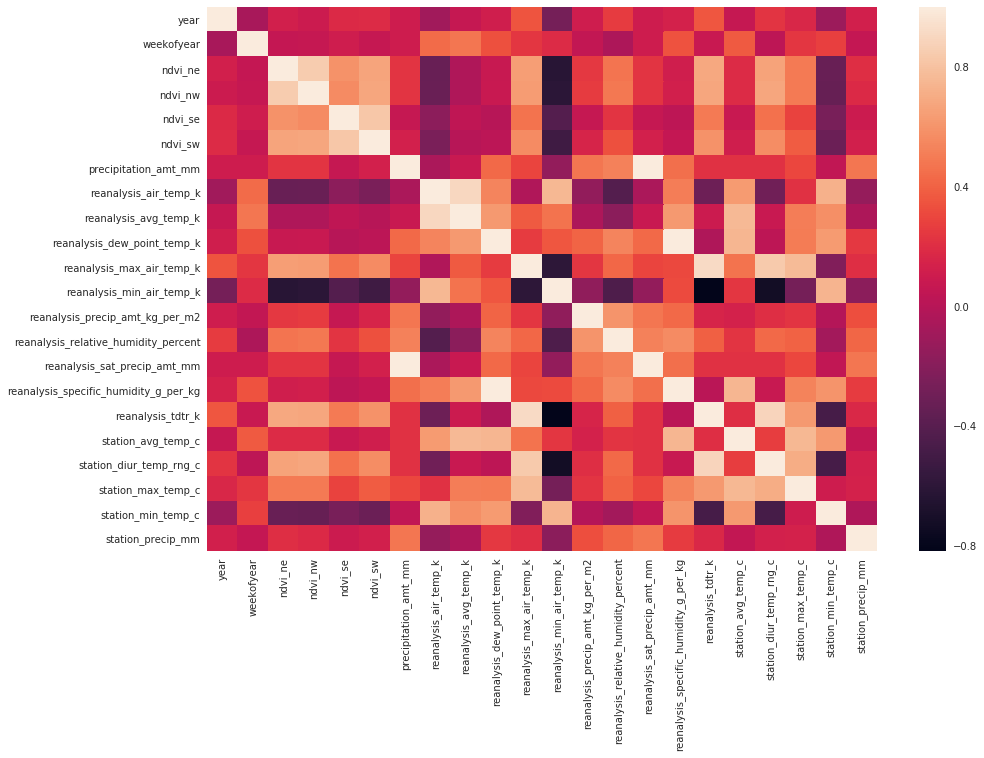

In [9]:
plt.subplots(figsize=(15,10))
sns.heatmap(full_data.corr())

In [10]:
# delete highly correlated feature
del full_data["precipitation_amt_mm"]
del full_data["reanalysis_dew_point_temp_k"]
del full_data["reanalysis_avg_temp_k"]
del full_data["reanalysis_tdtr_k"]

In [11]:
encoder = LabelEncoder()
full_data["week_start_date"] = encoder.fit_transform(full_data["week_start_date"])
full_data["city"] = encoder.fit_transform(full_data["city"])

In [12]:
full_data.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  237
ndvi_nw                                   63
ndvi_se                                   23
ndvi_sw                                   23
reanalysis_air_temp_k                     12
reanalysis_max_air_temp_k                 12
reanalysis_min_air_temp_k                 12
reanalysis_precip_amt_kg_per_m2           12
reanalysis_relative_humidity_percent      12
reanalysis_sat_precip_amt_mm              15
reanalysis_specific_humidity_g_per_kg     12
station_avg_temp_c                        55
station_diur_temp_rng_c                   55
station_max_temp_c                        23
station_min_temp_c                        23
station_precip_mm                         27
dtype: int64

In [13]:
missing_valued_feature = full_data.columns[4:]

impute = Imputer(missing_values='NaN', strategy='median', axis=0)
full_data[missing_valued_feature] = impute.fit_transform(full_data[missing_valued_feature])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Checking Outliers

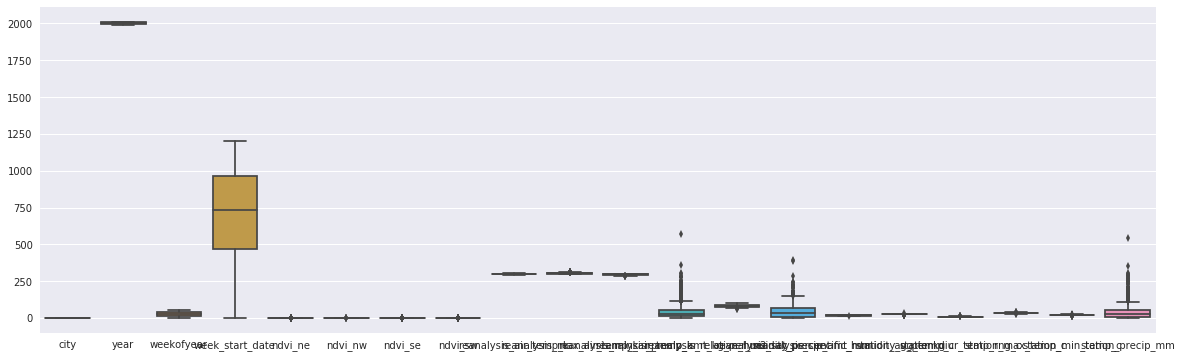

In [14]:
plt.subplots(figsize=(20,6))
sns.boxplot(data = full_data)

## Feature Scaling

In [15]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(full_data)
scaled_df = pd.DataFrame(data = scaled_data, columns = full_data.columns)
scaled_df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:322: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1.0,0.0,0.326923,0.000000,0.603031,0.506583,0.386418,0.395544,0.394806,0.122699,0.708029,0.056091,0.381614,0.031797,0.262659,0.430091,0.243013,0.174194,0.464,0.029450
1,1.0,0.0,0.346154,0.000831,0.651706,0.541376,0.321190,0.359233,0.478326,0.190184,0.744526,0.031446,0.479668,0.058423,0.418164,0.565350,0.198056,0.322581,0.640,0.015829
2,1.0,0.0,0.365385,0.001661,0.510055,0.569240,0.311879,0.384430,0.552877,0.165644,0.810219,0.045749,0.594415,0.088428,0.586900,0.565350,0.207776,0.354839,0.688,0.076201
3,1.0,0.0,0.384615,0.002492,0.609240,0.634483,0.438912,0.491150,0.579783,0.220859,0.788321,0.024365,0.552387,0.039324,0.566808,0.645897,0.232078,0.425806,0.728,0.007362
4,1.0,0.0,0.403846,0.003322,0.678770,0.649986,0.481601,0.509943,0.649290,0.251534,0.824818,0.021385,0.555396,0.019252,0.628226,0.802432,0.453220,0.535484,0.776,0.010676


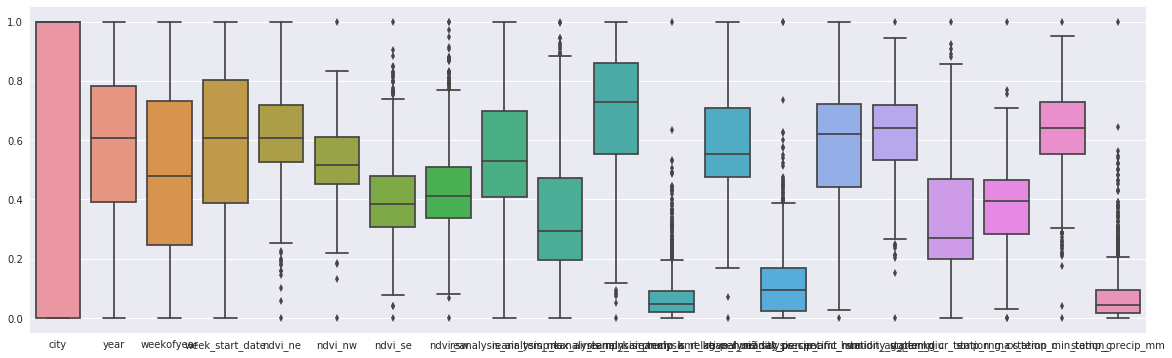

In [16]:
plt.subplots(figsize=(20,6))
sns.boxplot(data = scaled_df)

In [17]:
# detecting Outlier
# Inter Quartile Range is the distance between the 3rd Quartile and the first Qartile

minimum = 0
maximum = 0

def detect_outlier(feature):
    first_q = np.percentile(feature, 25)
    third_q = np.percentile(feature, 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    flag = False
    
    if(minimum > np.min(feature)):
        flag = True
    if(maximum < np.max(feature)):
        flag = True
    
    return flag

In [18]:
def  remove_outlier(feature):
    first_q = np.percentile(scaled_df[feature], 25)
    third_q = np.percentile(scaled_df[feature], 75)
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    
    mean = scaled_df[feature].median()
    
    scaled_df.loc[scaled_df[feature] < minimum, feature] = mean
    scaled_df.loc[scaled_df[feature] > maximum, feature] = mean

In [19]:
for i in range(len(scaled_df.columns)):
    if(detect_outlier(scaled_df[scaled_df.columns[i]])):
        print(scaled_df.columns[i], "Contains Outlier")

ndvi_ne Contains Outlier
ndvi_nw Contains Outlier
ndvi_se Contains Outlier
ndvi_sw Contains Outlier
reanalysis_max_air_temp_k Contains Outlier
reanalysis_min_air_temp_k Contains Outlier
reanalysis_precip_amt_kg_per_m2 Contains Outlier
reanalysis_relative_humidity_percent Contains Outlier
reanalysis_sat_precip_amt_mm Contains Outlier
reanalysis_specific_humidity_g_per_kg Contains Outlier
station_avg_temp_c Contains Outlier
station_diur_temp_rng_c Contains Outlier
station_max_temp_c Contains Outlier
station_min_temp_c Contains Outlier
station_precip_mm Contains Outlier


In [20]:
for k in range(15):
    for i in range(len(scaled_df.columns)):
        remove_outlier(scaled_df.columns[i])

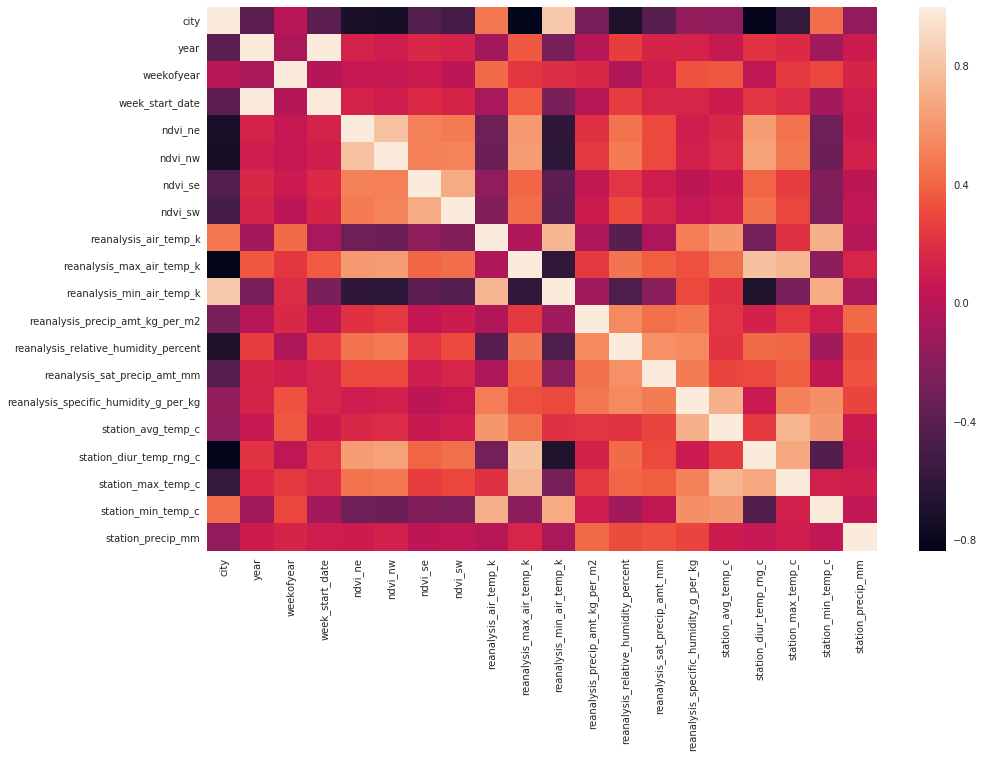

In [21]:
plt.subplots(figsize=(15,10))
sns.heatmap(scaled_df.corr())

In [22]:
del scaled_df["year"]

In [23]:
X_train = scaled_df.iloc[0:1456, :]
X_test = scaled_df.iloc[1456:, :]
y_train = train_label["total_cases"]

In [24]:
clf  = XGBClassifier(max_depth = 10,random_state = 7, n_estimators=220, eval_metric = 'auc', min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.8)
clf.fit(X_train, y_train)

pred = clf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, pred))
print("Precision:", precision_score(y_train, pred, average="weighted"))
print("Recall:", recall_score(y_train, pred,  average="weighted"))
print("F1:", f1_score(y_train, pred, average="weighted"))

Accuracy: 0.9203296703296703
Precision: 0.8753813316019697
Recall: 0.9203296703296703
F1: 0.893564671266597


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1142: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1142: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Highest accuracy on Training Data using ML classifier: 92%

In [25]:
confusion_matrix(y_train, pred,  labels=[1,0])

array([[ 59,   0],
       [  0, 100]])

In [26]:
test_pred = clf.predict(X_test)

In [27]:
sub_df = test.iloc[:, :3]

In [28]:
sub_df.insert(loc=3, column="total_cases", value=test_pred)

In [29]:
sub_df.to_csv('submission.csv', index=False)